<a href="https://colab.research.google.com/github/tpujianto/LendingClub_Loan_Prediction/blob/master/loan_predictions_EDA_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loan Prediction
## Based on Lending Club Data

A capstone project for Springboard Data Science Career Track Program.

The project goal is to train a classification model to predict bad loans on a major lending platform, Lending Club. The typical lending process:
* Applicants submit their loan applications to Lending Club
* Individual lenders can directly browse and select loan applications that they want to fund.

Eventually, borrowers pay interests and principals back to lenders.
 
With this business model, Lending Club is considered P2P lending. There’s still the risk of investors to run the risk of investing in a bad loan. 
This issue is to  be addressed in this project by developing a predictive model to identify bad loans by using information available on loan applications. Then, investors can make more objective and data-driven assessment of loan applications to minimize risk.


We can download dataset from Lending Club website: https://www.lendingclub.com/info/statistics.action.

However, it requires signing up as member to download the dataset. Thus, in this project, we will use dataset available from Kaggle. The dataset was downloaded from : https://www.kaggle.com/wordsforthewise/lending-club?select=rejected_2007_to_2018Q4.csv.gz

Unfortunately, this was updated a year ago, so, it's not the most recent data.

## Preparation

### Import Modules

In [ ]:
!pip install -U -q PyDrive

In [ ]:
# Essentials
import numpy as np
import pandas as pd
import datetime
import random

# Plots
import seaborn as sns
import matplotlib.pyplot as plt

# "magic" command to make plots show up in the notebook
%matplotlib inline 

from sklearn.preprocessing import LabelEncoder

# Ignore useless warnings
import warnings
warnings.filterwarnings(action="ignore")
pd.options.display.max_seq_items = 8000
pd.options.display.max_rows = 8000

# Google Colab
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

### Import Data

In [ ]:
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
link = 'https://drive.google.com/file/d/1CDnHyEBVsxjIHbiRPetYhHlChp3-u6pP/view?usp=sharing'

In [ ]:
id, fluff = link.split('=')
print (id) # Verify that you have everything after '='

https://drive.google.com/file/d/1CDnHyEBVsxjIHbiRPetYhHlChp3-u6pP/view?usp


In [ ]:
downloaded = drive.CreateFile({'id':'1CDnHyEBVsxjIHbiRPetYhHlChp3-u6pP'}) 
downloaded.GetContentFile('accepted_2007_to_2018Q4.csv')  
accepted_df = pd.read_csv('accepted_2007_to_2018Q4.csv')
# Dataset is now stored in a Pandas Dataframe

## Exploratory Data Analysis

### Print Data

In [ ]:
accepted_df.head(10).T

,0,1,2,3,4,5,6,7,8,9
id,68407277,68355089,68341763,66310712,68476807,68426831,68476668,67275481,68466926,68616873
member_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
loan_amnt,3600,24700,20000,35000,10400,11950,20000,20000,10000,8000
funded_amnt,3600,24700,20000,35000,10400,11950,20000,20000,10000,8000
funded_amnt_inv,3600,24700,20000,35000,10400,11950,20000,20000,10000,8000
term,36 months,36 months,60 months,60 months,60 months,36 months,36 months,36 months,36 months,36 months
int_rate,13.99,11.99,10.78,14.85,22.45,13.44,9.17,8.49,6.49,11.48
installment,123.03,820.28,432.66,829.9,289.91,405.18,637.58,631.26,306.45,263.74
grade,C,C,B,C,F,C,B,B,A,B
sub_grade,C4,C1,B4,C5,F1,C3,B2,B1,A2,B5


For this project, we would like to focus on the accepted loan. We are going to predict if the loan will be high risk or low risk.

In [ ]:
# Encoding the `loan_status`
# status 1: 'Charged Off', 'Late (16-30 days)', 'Late (31-120 days)', 'Default'
# status 0: 'Fully Paid'
accepted_df['target'] = 1
accepted_df.loc[accepted_df['loan_status'] == 'Fully Paid', 'target'] = 0

In [ ]:
data_null = accepted_df.isnull().sum() / len(accepted_df)
data_null = data_null.reset_index()
data_null = data_null.rename(columns={'index': 'feature', 0: 'missing'})

In [ ]:
data_null = data_null.fillna(value=0)

feature_list = data_null['feature']

null_rate = []
not_null_rate = []
category = []
data_unique = []

for feature in feature_list:
    null_rate.append(accepted_df[accepted_df[feature].isnull()]['target'].mean())
    not_null_rate.append(accepted_df[~accepted_df[feature].isnull()]['target'].mean())
    category.append(accepted_df[feature].dtypes)
    data_unique.append(len(accepted_df[feature].unique()))

data_null['dtype'] = category    
data_null['null mean'] = null_rate
data_null['not null mean'] = not_null_rate
data_null['unique'] = data_unique

data_null = data_null.reset_index(drop=True)

data_null[['feature', 'missing', 'dtype', 'null mean', 
           'not null mean', 'unique']]

,feature,missing,dtype,null mean,not null mean,unique
0,id,0.000000,object,NaN,0.523709,2260701
1,member_id,1.000000,float64,0.523709,NaN,1
2,loan_amnt,0.000015,float64,1.000000,0.523702,1573
3,funded_amnt,0.000015,float64,1.000000,0.523702,1573
4,funded_amnt_inv,0.000015,float64,1.000000,0.523702,10058
5,term,0.000015,object,1.000000,0.523702,3
6,int_rate,0.000015,float64,1.000000,0.523702,674
7,installment,0.000015,float64,1.000000,0.523702,93302
8,grade,0.000015,object,1.000000,0.523702,8
9,sub_grade,0.000015,object,1.000000,0.523702,36


### Initial Thougths

Since The Lending Club was launched in 2012, there may have been significant changes in its loan portfolios since then. The code transforms the issue date of the loans so that we have use them in further analysis.

Lending Club was launched back in 2012. Since then, the platform has gotten more exposure and popularity. Thus, we expected significant increase in its loan portfolios over the years.

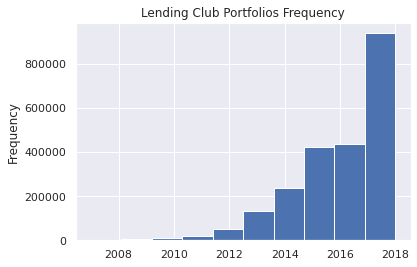

In [ ]:
accepted_df.term = accepted_df.term.apply(str)
accepted_df['term'] = accepted_df['term'].apply(lambda x: x.strip().split(" ")[0])

accepted_df.issue_d = pd.to_datetime(accepted_df.issue_d)
accepted_df['issue_yr'] = accepted_df.issue_d.dt.year

sns.set()
accepted_df['issue_yr'].plot.hist()
plt.title('Lending Club Portfolios Frequency')
plt.show()

### Data transformation


I decide to drop several columns because they are a linear combination of others, or they contain too little information. 

As for Zip Code, we only have the first 3 number so this feature is not helpful.

In [ ]:
accepted_df = accepted_df.drop(['title', 'funded_amnt'], axis = 1)
accepted_df = accepted_df.drop(['out_prncp_inv','total_rec_prncp','total_pymnt_inv'], axis = 1)
accepted_df = accepted_df.drop(['fico_range_low', 'last_fico_range_low',
                         'avg_cur_bal',
                         'addr_state', 'initial_list_status', 'pymnt_plan',
                         'application_type', 'hardship_flag', 'disbursement_method',
                          'debt_settlement_flag','sub_grade',
                         'zip_code', 'id','policy_code','tax_liens', 'tax_liens'], axis = 1)

Furthermore, I transform several variables into the date type for easier analysis later.

In [ ]:
accepted_df.home_ownership = accepted_df.home_ownership.replace(['ANY', 'NONE','OTHER'], 'RENT')

# transform to pandas DateTime object
accepted_df['issue_yr'] = accepted_df.issue_d.dt.year
accepted_df['earliest_cr_line'] = pd.to_datetime(accepted_df.earliest_cr_line)
accepted_df['early_cr_yr'] = accepted_df.earliest_cr_line.dt.year

median_year = accepted_df.emp_length.value_counts(ascending = False).index[0]
accepted_df.loc[:, 'emp_length'] = accepted_df.loc[:, 'emp_length'].fillna(median_year)

accepted_df.emp_length = accepted_df.emp_length.replace(['10+ years'], '10 years')
accepted_df.emp_length = accepted_df.emp_length.replace(['< 1 year'], '0 years')

accepted_df.emp_length = accepted_df.emp_length.apply(lambda x: int(str(x).split(' ')[0]))
print(accepted_df.emp_length.value_counts())

accepted_df.loc[:, 'emp_title'] = accepted_df.loc[:, 'emp_title'].fillna('other')
accepted_df.emp_title = accepted_df.emp_title.apply(lambda x: x.lower())
accepted_df.emp_title = accepted_df.emp_title.replace(['lpn','registered nurse', 'rn'], 'nurse')

10    894945
2     203677
0     189988
3     180753
1     148403
5     139698
4     136605
6     102628
7      92695
8      91914
9      79395
Name: emp_length, dtype: int64


### Change of rates through time


Each loan receives a grade that ranges from G through A. Starting November 2017, grade F and G are no longer used. These codes will plot the average interest rate according to grate through time.

In [ ]:
rate = pd.pivot_table(accepted_df[accepted_df['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc=np.mean)
rate.shape # 77, 1
rate = rate.reset_index()

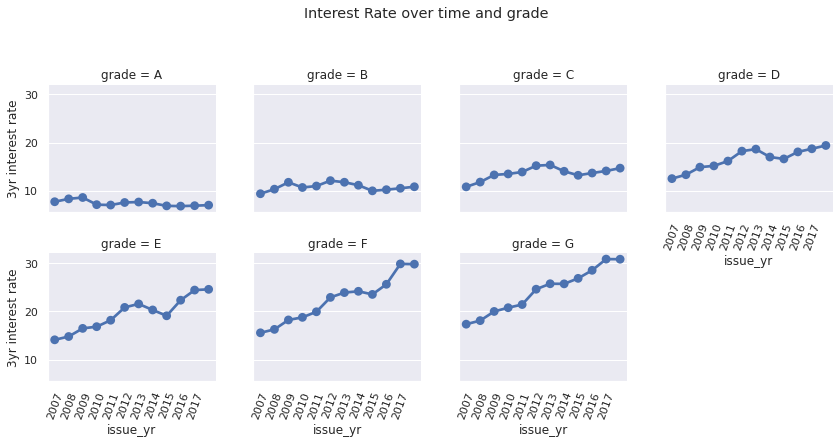

In [ ]:
g = sns.FacetGrid(rate, col = 'grade', col_wrap = 4)
g = g.map(sns.pointplot, "issue_yr", "int_rate")

labels = np.arange(2007, 2018, 1)
labels = [str(i) for i in labels]
g = g.set_xticklabels(labels, rotation=70)
g = g.set_ylabels("3yr interest rate")

plt.subplots_adjust(top=0.8)
g.fig.suptitle('Interest Rate over time and grade')
plt.show()

We can see that interest rate for grade D, E, F, G increase quickly from 2014.

We have very few data points from 2007 to 2014. Let's take a closer look to see if this increase in average rate is not due to the small number of observations.



In [ ]:
# Number of observations for each grade
# to verify the variance of rates
rate_count = pd.pivot_table(accepted_df[accepted_df['term'] == '36'],index=["grade","issue_yr"],values=["int_rate"], aggfunc='count')
rate_count = rate_count.unstack('grade')
rate_count

int_rate                                       
grade           A       B      C      D     E     F    G
issue_yr                                                
2007.0         78      98    141     99   100    52   35
2008.0        318     594    580    419   285   111   86
2009.0       1203    1445   1348    817   308   105   55
2010.0       2567    2805   2070   1253   336    91   34
2011.0       5579    4722   2203   1261   272    54   10
2012.0      10753   16805   9902   5088   795   103   24
2013.0      17057   40313  24693  14505  3231   608   15
2014.0      35333   53460  44042  20510  7066  1980  179
2015.0      70132   91783  77457  32740  9450  1363  248
2016.0      66862  114783  92317  36707  9932  2364  530
2017.0      76300  108943  88425  34572  9837  1574  768
2018.0     122999   99155  76680  36228  9179   312  118

### Borrowing Purpose

In [ ]:
purpose = accepted_df.purpose.value_counts().sort_values(ascending=False)
print(purpose)

debt_consolidation    1277877
credit_card            516971
home_improvement       150457
other                  139440
major_purchase          50445
medical                 27488
small_business          24689
car                     24013
vacation                15525
moving                  15403
house                   14136
wedding                  2355
renewable_energy         1445
educational               424
Name: purpose, dtype: int64


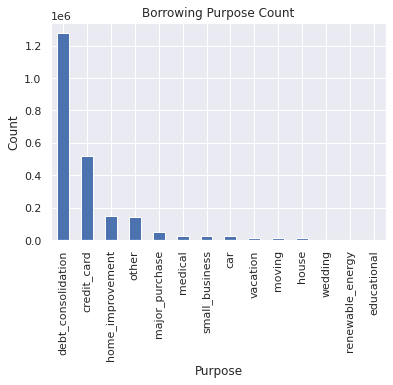

In [ ]:
 sns.set()
purpose.plot.bar()
plt.title('Borrowing Purpose Count')
plt.xlabel('Purpose')
plt.ylabel('Count')
plt.show()

### Distribution of Income across Grade


Let's take a leap of faith and only examine the loans where income has been verified. The variable verification status can take one of 3 values: Verified, Source Verified or Not Verified. Here I only filtered for loans whose verification status is different from 'Not Verified'.

I put a cap on the high income (95% percentile), because the high income level can be in the amount of $500,000, which is not that regular and will distort the chart.

In [ ]:
incomeVerified = accepted_df[accepted_df['verification_status'] != 'Not Verified']
incomeVerified = incomeVerified[['grade','annual_inc']]
quantile_low = incomeVerified['annual_inc'].min()
quantile_high = incomeVerified['annual_inc'].quantile(0.95)
filtered = incomeVerified[(incomeVerified['annual_inc'] > quantile_low) & (incomeVerified['annual_inc'] <= quantile_high)]

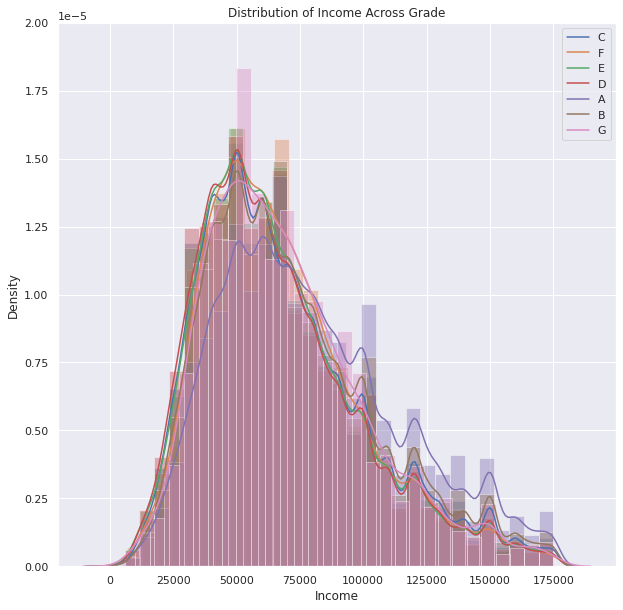

In [ ]:
grade_list = filtered['grade'].unique()
sns.set()
plt.figure(figsize=(10,10))
for i in range(len(grade_list)):
    data = filtered[filtered['grade'] == grade_list[i]]['annual_inc'].values
    sns.distplot(data, bins = 30)

plt.legend(grade_list)
plt.title("Distribution of Income Across Grade")
plt.xlabel('Income')
plt.ylim(ymax = 0.00002)
plt.show()

There seems to be a slight difference in income level across grade, with one grade has a high density of income above $100,000. Perhaps it may not be beneficial to dive too deep into it, except having a brief look at the median income accross each grade. We do see that while other grades seem to have similar median incomes, grade A does stand out.



In [ ]:
# Median of incomes in each grade
income_median = pd.pivot_table(filtered, values = 'annual_inc', index = 'grade', aggfunc = np.median)
income_median

,annual_inc
grade,
A,74000.0
B,65000.0
C,62000.0
D,60000.0
E,60000.0
F,62891.0
G,65000.0


### Income Distribution by Professions


Because of the large number of observations that we have, we can construct a reliable distribution of annual incomes.But first, further transformation:

* Filtering for loans where the reported income is less than 1 million USD
* Filtering for loans where Debt-to-Income ratio is less than 100 percent. If it is greater than or equal to 100, I wonder why we would have made such loans in the first place. I could have been more careful by capping dti value at 100.

Changing employment years into numeric
* Filling unknown values for home-ownership as Rent
* Standardizing the values of employment title (emp_title)

Because people will most likely lie on their incomes when their income is low, we can filter out for data if:

* Income is lower than \$70,000 but has been verified by Lending Club

* Income is higher than \$70,000 but lower than \$120,000

* Income is higher than \$120,000 but has been verified by Lending Club

The choice of limit of \$70,000 and \$120,000 is arbitrary to filter out loans where income levels seem unrealistic.

In [ ]:
pd.options.display.float_format = '{:,.0f}'.format
salary_limit = 7e4

emp_annual_all = accepted_df.loc[((accepted_df['annual_inc'] >= 1.2e5) & (accepted_df['verification_status'] == 'Verified')) 
                              | ((accepted_df['annual_inc'] >= salary_limit) & (accepted_df['annual_inc'] < 1.2e5)) 
                              | ((accepted_df['annual_inc'] < salary_limit) & (accepted_df['verification_status'] == 'Verified')),
                              ['emp_title','annual_inc']].groupby('emp_title')


summ_inc = emp_annual_all.agg(['min','mean','median','max', 'count'])
summ_inc.columns = summ_inc.columns.levels[1]
summ_inc = summ_inc.sort_values(by = ['count','min'], ascending = False)

# Filter for professions with more than 500 observations
summ_inc = summ_inc[summ_inc['count'] >= 500].sort_values(by = ['count','min'], ascending = False)
summ_inc

,min,mean,median,max,count
emp_title,,,,,
other,0,"55,211","50,000","3,330,432",98333
nurse,"10,000","84,118","81,000","320,000",29515
teacher,0,"74,662","75,000","367,500",22437
manager,"2,500","84,846","82,000","4,800,000",22218
owner,0,"93,432","85,000","1,000,000",13998
driver,0,"74,401","75,000","1,000,000",10264
supervisor,500,"76,947","75,340","780,000",9738
sales,0,"87,748","80,000","2,000,000",8722
project manager,0,"92,144","90,000","460,000",8616


This dataset does have a large diversity in the professions and income level of borrowers. Personally, what I find most interesting is that:

* Teacher and Nurse, despite being regarded as respectable professions in some regions in the world, are the 2 most common professions on Lending Club. Their minimum salary is only around \$12,000, which is lower than US' Poverty Level for individual.

* Police officer has a minimum salary of \$32,000

* Many people with annual income higher than \$400,000 and even \$1,000,000 still use Lending Club as a way to borrow cheaply. I can dive down into the purpose of the loans later, but that may not offer much benefit for data modeling.

* Some jobs traditionally associated with high income have very min income, such as attorney, director, enginee. And these salaries have been verified by Lending Club. It's likely that these salaries miss a 0's. This is worthy of attention.

### Fico range and grade

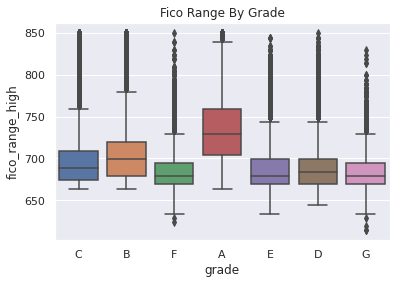

In [ ]:
sns.boxplot(data=accepted_df, x='grade', y='fico_range_high')
plt.title('Fico Range By Grade')
plt.show()

### Charge off rate vs Verification status

My hypothesis is that Lending Club tends to take the effort to verify a borrower's income only when it is high. To quickly examine this hypothesis, I look at the charge off rate across each grade depending on whether the income is Verified or not.

I define that a loan is considered charge-off when the value of loan_status is Charged Off or Default. I can expand it to 90 days behind dues, but it does not make that large of a difference.

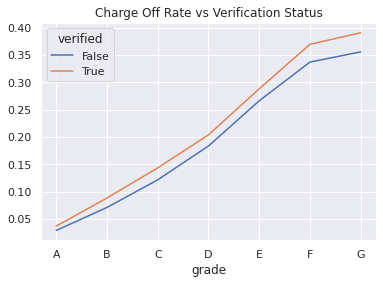

In [ ]:
accepted_df['verified'] = accepted_df['verification_status'] == 'Verified'
grade_yr_loanamnt = pd.pivot_table(accepted_df,index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default = pd.pivot_table(accepted_df[(accepted_df.loan_status == 'Charged Off') | (accepted_df.loan_status == 'Default')],
                                           index=["grade","verified"], values=['loan_amnt'], aggfunc=np.sum)

grade_yr_loanamnt_default.columns = ['Charged_off']

loan_verified = pd.merge(grade_yr_loanamnt, grade_yr_loanamnt_default, left_index = True, right_index = True)
loan_verified['chargeoff_rate']  = loan_verified['Charged_off'] /  loan_verified['loan_amnt'] 

loan_verified_unstack = loan_verified.unstack("verified")
verified_chargedoff = loan_verified_unstack['chargeoff_rate']
verified_chargedoff.plot()
plt.title('Charge Off Rate vs Verification Status')
plt.show()

## Missing Values

### Categorical Variable

In [ ]:
# for `emp_length`, since the order matters, we will fill the missing value with mode
emp_length_mode = accepted_df['emp_length'].mode()[0]
accepted_df['emp_length'] = accepted_df['emp_length'].fillna(value=emp_length_mode)

### Numerical Variable

In [ ]:
# fill the missing value with the median to make it more robust
dti_median = accepted_df['dti'].median()
accepted_df['dti'] = accepted_df['dti'].fillna(value=dti_median)

In [ ]:
# for `inq_last_6mths`, fill the missing value with the mode
inq_last_6mths_mode = accepted_df['inq_last_6mths'].mode()[0]
accepted_df['inq_last_6mths'] = accepted_df['inq_last_6mths'].fillna(value=inq_last_6mths_mode)

In [ ]:
# for `revol_util`, fill the missing value with the median to make it more robust
revol_util_median = accepted_df['revol_util'].median()
accepted_df['revol_util'] = accepted_df['revol_util'].fillna(value=revol_util_median)

In [ ]:
# for `bc_open_to_buy`, fill the missing value with the median to make it more robust
bc_open_to_buy_median = accepted_df['bc_open_to_buy'].median()
accepted_df['bc_open_to_buy'] = accepted_df['bc_open_to_buy'].fillna(value=bc_open_to_buy_median)

In [ ]:
# for `bc_util`, fill the missing value with the median to make it more robust
bc_util_median = accepted_df['bc_util'].median()
accepted_df['bc_util'] = accepted_df['bc_util'].fillna(value=bc_util_median)

In [ ]:
# for `mo_sin_old_il_acct`, fill the missing value with the median to make it more robust
mo_sin_old_il_acct_median = accepted_df['mo_sin_old_il_acct'].median()
accepted_df['mo_sin_old_il_acct'] = accepted_df['mo_sin_old_il_acct'].fillna(value=mo_sin_old_il_acct_median)

In [ ]:
# for `mths_since_recent_bc`, fill the missing value with the median to make it more robust
mths_since_recent_bc_median = accepted_df['mths_since_recent_bc'].median()
accepted_df['mths_since_recent_bc'] = accepted_df['mths_since_recent_bc'].fillna(value=mths_since_recent_bc_median)

In [ ]:
# for `mths_since_recent_inq`, fill the missing value with the median to make it more robust
mths_since_recent_inq_median = accepted_df['mths_since_recent_inq'].median()
accepted_df['mths_since_recent_inq'] = accepted_df['mths_since_recent_inq'].fillna(value=mths_since_recent_inq_median)

In [ ]:
# for `num_rev_accts`, fill the missing value with 0
accepted_df['num_rev_accts'] = accepted_df['num_rev_accts'].fillna(value=0)

In [ ]:
# for `num_tl_120dpd_2m`, fill the missing value with 0
accepted_df['num_tl_120dpd_2m'] = accepted_df['num_tl_120dpd_2m'].fillna(value=0)

In [ ]:
# for `percent_bc_gt_75`, fill the missing value with the median to make it more robust
percent_bc_gt_75_median = accepted_df['percent_bc_gt_75'].median()
accepted_df['percent_bc_gt_75'] = accepted_df['percent_bc_gt_75'].fillna(value=percent_bc_gt_75_median)

### More Visualizing

In order to save some computational time, for visualization purposes, we will only use 100,000 observations.

In [ ]:
data_plot= accepted_df.sample(n=100000, replace=False, random_state=21)

In [ ]:
# define categorical and numerical features
cat_features = ['term', 'home_ownership', 'verification_status', 'purpose',
                'grade']

num_features = ['loan_amnt', 'int_rate', 'emp_length', 
                'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 
                'revol_bal', 'revol_util', 'total_acc', 'collections_12_mths_ex_med', 
                'acc_now_delinq', 'tot_coll_amt', 'tot_cur_bal', 'total_rev_hi_lim', 
                'acc_open_past_24mths', 'bc_open_to_buy', 'bc_util', 
                'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 
                'mo_sin_old_rev_tl_op', 'mo_sin_rcnt_rev_tl_op', 'mo_sin_rcnt_tl', 
                'mort_acc', 'mths_since_recent_bc', 'mths_since_recent_inq',
                'num_accts_ever_120_pd', 'num_actv_bc_tl', 'num_actv_rev_tl',
                'num_bc_sats', 'num_bc_tl', 'num_il_tl', 'num_op_rev_tl',
                'num_rev_accts', 'num_rev_tl_bal_gt_0', 'num_sats', 'num_tl_120dpd_2m',
                'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'num_tl_op_past_12m', 
                'pct_tl_nvr_dlq', 'percent_bc_gt_75', 'pub_rec_bankruptcies',
                'tot_hi_cred_lim', 'total_bal_ex_mort', 'total_bc_limit',
                'total_il_high_credit_limit']

features = cat_features + num_features

# define numerical and categorical features
print('Categorical feature:\t', len(cat_features))
print('Numerical feature:\t', len(num_features))
print('Total feature:\t\t', len(features))

Categorical feature:	 5
Numerical feature:	 50
Total feature:		 55


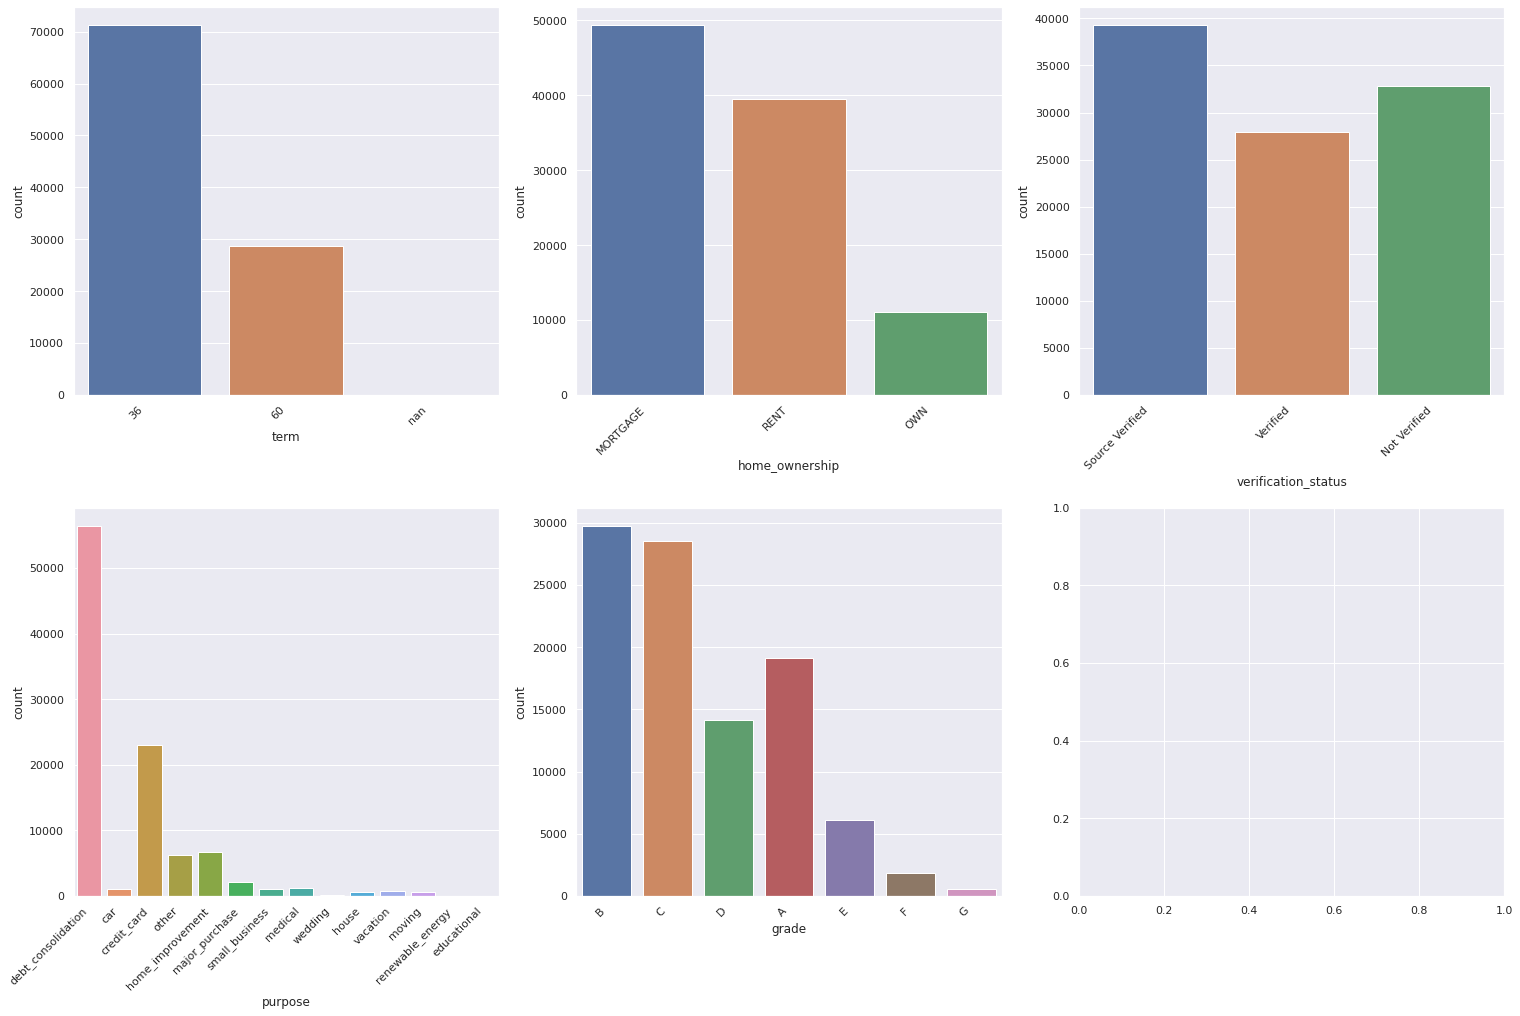

In [ ]:
num_plots = len(cat_features)
total_cols = 3
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(cat_features):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.countplot(x=var, data=data_plot, ax=axs[row][pos], orient='h')
    plot.set_xticklabels(plot.get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

In [ ]:
num_features_to_plot = ['loan_amnt', 'funded_amnt_inv', 'int_rate', 'installment',
       'emp_length', 'annual_inc', 'dti', 'delinq_2yrs', 'fico_range_high',
       'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record',
       'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc',
       'out_prncp', 'total_pymnt', 'total_rec_int', 'total_rec_late_fee',
       'tot_cur_bal', 'total_rev_hi_lim']

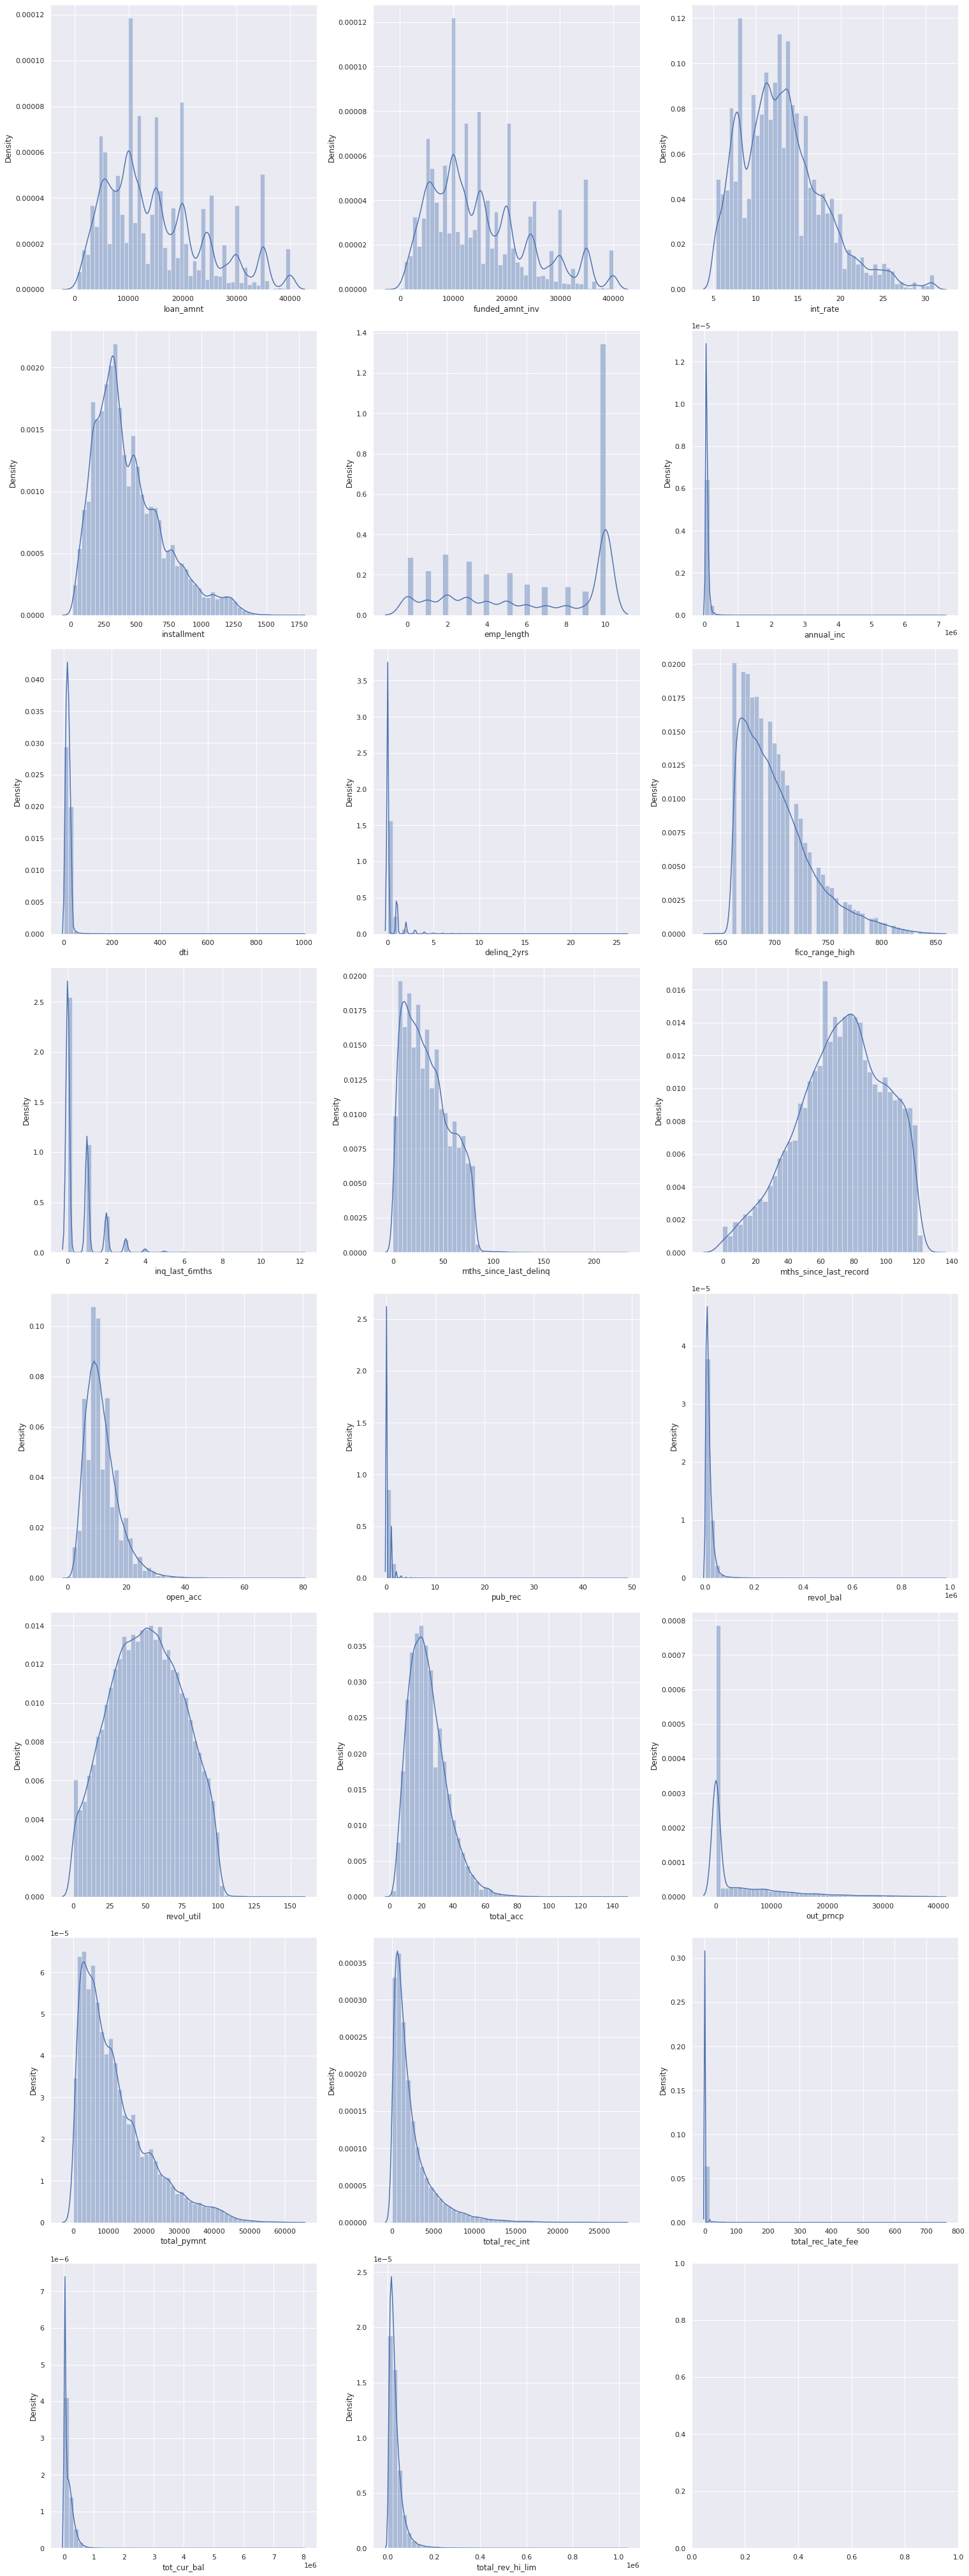

In [ ]:
num_plots = len(num_features_to_plot)
total_cols = 3
total_rows = num_plots//total_cols + 1
fig, axs = plt.subplots(nrows=total_rows, ncols=total_cols,
                        figsize=(7*total_cols, 7*total_rows), constrained_layout=True)
for i, var in enumerate(num_features_to_plot):
    row = i//total_cols
    pos = i % total_cols
    plot = sns.distplot(data_plot[var].dropna(), ax=axs[row][pos])

plt.show()

### Correlation Heatmap

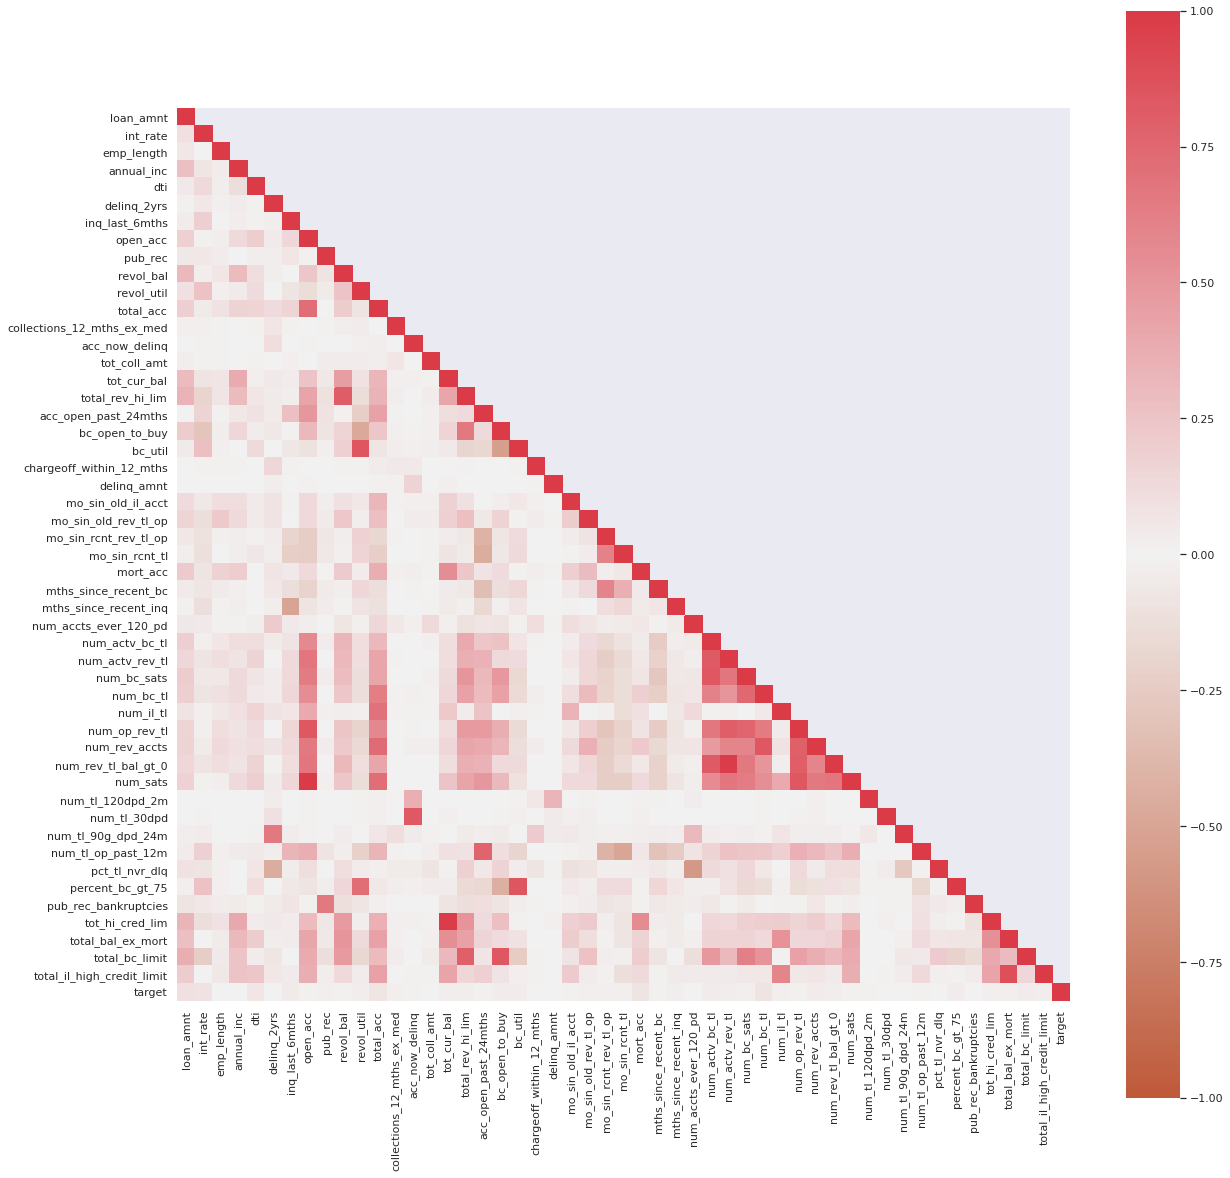

In [ ]:
# calculate the pair-wise correlation
subset = num_features + ['target']
data_corr = data_plot[subset]
corrMatt = data_corr.corr()      

mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,20)
# Generate a custom diverging colormap
cmap = sns.diverging_palette(22, 10, as_cmap=True)
sns.heatmap(corrMatt, mask=mask,vmax=1, vmin=-1,
    square=True, cmap=cmap)

plt.show()



We can see from the heatmap that there are several highly correlated features. Highly correlated features can affect the accuracy of regression model. We will find and drop highly correlated features.

In [ ]:
correlated_features = set()

for i in range(len(corrMatt.columns)):
    for j in range(i):
        if abs(corrMatt.iloc[i, j]) > 0.8:
            colname = corrMatt.columns[i]
            correlated_features.add(colname)

In [ ]:
print(correlated_features)

{'total_bc_limit', 'percent_bc_gt_75', 'num_op_rev_tl', 'num_rev_tl_bal_gt_0', 'num_bc_sats', 'num_rev_accts', 'total_il_high_credit_limit', 'num_sats', 'bc_util', 'num_tl_30dpd', 'total_rev_hi_lim', 'num_actv_rev_tl', 'tot_hi_cred_lim'}


In [ ]:
for element in list(correlated_features):
    features.remove(element)

In [ ]:
features.append('target')

In [ ]:
data_clean = accepted_df[features]


In [ ]:
# save clean data to drive
from google.colab import drive
drive.mount('drive')

Mounted at drive


In [ ]:
drive.mount('/drive')

Mounted at /drive


In [ ]:
data_clean.to_csv('/drive/My Drive/data/data_clean.csv')